<h1 ><big><center>MSO 3.4 - Deep Structured Learning</center></big></h1>

<h2><big><center> BE 2 - GANs and cGAN </center></big></h2>

<h5><big><center>Adapted from <i>Projet d'Option</i> of : Mhamed Jabri, Martin Chauvin, Ahmed Sahraoui, Zakariae Moustaïne and Taoufik Bouchikhi


<p align="center">
<img height=300px src="https://cdn-images-1.medium.com/max/1080/0*tJRy5Chmk4XymxwN.png"/></p>
<p align="center"></p>

The aim of this assignment is to discover GANs, understand how they are implemented and then explore one specific architecture of GANs that allows us to perform image to image translation (which corresponds to the picture that you can see above this text ! )

Before starting the exploration of the world of GANs, here's  what students should do and send back for this assignement : 
* In the "tutorial" parts of this assignement that focus on explaining new concepts, you'll find <font color='red'>**questions**</font>  that aim to test your understanding of those concepts. 
* In some of the code cells, you'll have to complete the code and you'll find a "TO DO" explaining what you should implement.

# Part1: DC-GAN

In this part, we aim to learn and understand the basic concepts of **Generative Adversarial Networks** through a DCGAN and generate new celebrities from the learned network after showing it real celebrities. For this purpose, please study the tutorial here: https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html


##Work to do
Now we want to generate handwritten digits using the MNIST dataset. It is available within torvision package (https://pytorch.org/vision/stable/generated/torchvision.datasets.MNIST.html#torchvision.datasets.MNIST)

Please re-train the DCGAN and display some automatically generated handwritten digits.



cuda
Epoch [0/20], d_loss: 0.0022225186694413424, g_loss: 7.581844329833984
Epoch [1/20], d_loss: 0.005426987074315548, g_loss: 6.886549949645996
Epoch [2/20], d_loss: 0.01954970508813858, g_loss: 7.922786235809326
Epoch [3/20], d_loss: 0.0201672725379467, g_loss: 6.871812343597412
Epoch [4/20], d_loss: 0.024362564086914062, g_loss: 6.063836097717285
Epoch [5/20], d_loss: 0.09851087629795074, g_loss: 4.0679144859313965
Epoch [6/20], d_loss: 0.2406003326177597, g_loss: 4.606659412384033
Epoch [7/20], d_loss: 0.20959554612636566, g_loss: 3.9828104972839355
Epoch [8/20], d_loss: 0.44713860750198364, g_loss: 5.378398895263672
Epoch [9/20], d_loss: 0.1723831593990326, g_loss: 4.158991813659668
Epoch [10/20], d_loss: 0.1491287350654602, g_loss: 2.674863815307617
Epoch [11/20], d_loss: 0.6381869316101074, g_loss: 3.86030650138855
Epoch [12/20], d_loss: 0.28593653440475464, g_loss: 2.2167184352874756
Epoch [13/20], d_loss: 0.19371789693832397, g_loss: 3.5312886238098145
Epoch [14/20], d_loss: 

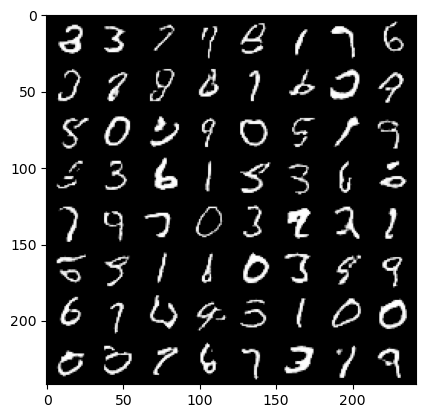

In [3]:
#TO DO: your code here to adapt the code from the tutorial to experiment on MNIST dataset

import torch
from torch import nn
from torchvision import datasets, transforms
from torchvision.utils import save_image
import matplotlib.pyplot as plt

if torch.cuda.is_available():
    print('cuda')
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
    print('cpu')

# Load MNIST dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=128, shuffle=True)

# Define Generator and Discriminator
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d(100, 256, 4, 1, 0, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            # state size. 256 x 4 x 4
            nn.ConvTranspose2d(256, 128, 3, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            # state size. 128 x 7 x 7
            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            # state size. 64 x 14 x 14
            nn.ConvTranspose2d(64, 1, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. 1 x 28 x 28
        )

    def forward(self, input):
        return self.main(input)

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            # input is 1 x 28 x 28
            nn.Conv2d(1, 64, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. 64 x 14 x 14
            nn.Conv2d(64, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. 128 x 7 x 7
            nn.Conv2d(128, 256, 3, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. 256 x 4 x 4
            nn.Conv2d(256, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input).view(-1, 1).squeeze(1)

# Create the models
generator = Generator().to(device)
discriminator = Discriminator().to(device)

# Define loss function and optimizers
criterion = nn.BCELoss()
optimizer_g = torch.optim.Adam(generator.parameters(), lr=0.0002)
optimizer_d = torch.optim.Adam(discriminator.parameters(), lr=0.0002)

# hyperparameters
batch_size = 64
epochs = 20

# Train the DCGAN
for epoch in range(epochs):
    for i, (images, _) in enumerate(dataloader):
        current_batch_size = images.size(0)  # Get the size of the current batch

        # Train Discriminator
        real_images = images.to(device)
        real_labels = torch.ones(current_batch_size).to(device)  # Adjust the size of the labels
        fake_labels = torch.zeros(current_batch_size).to(device)  # Adjust the size of the labels

        # Real images
        real_outputs = discriminator(real_images)
        d_loss_real = criterion(real_outputs, real_labels)

        # Fake images
        z = torch.randn(current_batch_size, 100, 1, 1).to(device)
        fake_images = generator(z)
        fake_outputs = discriminator(fake_images)
        d_loss_fake = criterion(fake_outputs, fake_labels)

        # Backprop and optimize
        d_loss = d_loss_real + d_loss_fake
        discriminator.zero_grad()
        d_loss.backward()
        optimizer_d.step()

        # Train Generator
        z = torch.randn(current_batch_size, 100, 1, 1).to(device)
        fake_images = generator(z)
        outputs = discriminator(fake_images)

        # Backprop and optimize
        g_loss = criterion(outputs, real_labels)
        generator.zero_grad()
        g_loss.backward()
        optimizer_g.step()

    print(f'Epoch [{epoch}/{epochs}], d_loss: {d_loss.item()}, g_loss: {g_loss.item()}')

# Generate new handwritten digits
noise = torch.randn(64, 100, 1, 1).to(device)
generated_images = generator(noise)
save_image(generated_images.view(64, 1, 28, 28), 'generated_images.png')

# Display the generated images
img = plt.imread('generated_images.png')
plt.imshow(img)
plt.show()

# Part2: Conditional GAN (cGAN)

Let's take the example of the set described in the next picture.
![Map to satellite picture](https://raw.githubusercontent.com/Neyri/Projet-cGAN/master/BE/img/map_streetview.png)

We have a picture of a map (from Google Maps) and we want to create an image of what the satellite view may look like.

As we are not only trying to generate a random picture but a mapping between a picture to another one, we can't use the standard GAN architecture. We will then use a cGAN introduced in this [paper](https://arxiv.org/pdf/1611.07004.pdf).

A cGAN is a supervised GAN aiming at mapping a label picture to a real one or a real picture to a label one. As you can see in the diagram below, the discriminator will take as input a pair of images and try to predict if the pair was generated or not. The generator will not only generate an image from noise but will also use an image (label or real) to generate another one (real or label).
![Diagram of how a cGan works](https://raw.githubusercontent.com/Neyri/Projet-cGAN/master/BE/img/cgan_map.png)


### Generator

In the cGAN architecture, the generator chosen is a U-Net.
![U-Net](https://raw.githubusercontent.com/Neyri/Projet-cGAN/master/BE/img/unet.png)

A U-Net takes as input an image, and outputs another image. 

It can be divided into 2 subparts : an encoder and a decoder. 
* The encoder takes the input image and reduces its dimension to encode the main features into a vector. 
* The decoder takes this vector and map the features stored into an image.

A U-Net architecture is different from a classic encoder-decoder in that every layer of the decoder takes as input the previous decoded output as well as the output vector from the encoder layers of the same level. It allows the decoder to map low frequencies information encoded during the descent as well as high frequencies from the original picture. 

![U-Net](https://www.researchgate.net/profile/Baris_Turkbey/publication/315514772/figure/fig2/AS:485824962797569@1492841105670/U-net-architecture-Each-box-corresponds-to-a-multi-channel-features-maps-The-number-of.png)

The architecture we will implement is the following (the number in the square is the number of filters used).
![UNet Architecture](https://raw.githubusercontent.com/Neyri/Projet-cGAN/master/BE/img/unet_architecture.png)

The encoder will take as input a colored picture (3 channels: RGB), it will pass through a series of convolution layers to encode the features of the picture. It will then be decoded by the decoder using transposed convolutional layers. These layers will take as input the previous decoded vector AND the encoded features of the same level. 

Now, let's create or cGAN to generate facades from a template image. For this purpose, we will use the "Facade" dataset available at http://cmp.felk.cvut.cz/~tylecr1/facade/.


Let's first create a few classes describing the layers we will use in the U-Net.

In [148]:
# Importing all the libraries needed
import matplotlib.pyplot as plt
import imageio
import glob
import random
import os
import numpy as np
import math
import itertools
import time
import datetime
import cv2
from pathlib import Path
from PIL import Image

from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision.utils import save_image, make_grid
from torchvision import datasets
from torch.autograd import Variable

import torch.nn as nn
import torch.nn.functional as F
import torch

In [149]:
# code adapted from https://github.com/milesial/Pytorch-UNet/blob/master/unet/unet_parts.py

# Input layer
class inconv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(inconv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size=4, padding=1, stride=2),
            nn.LeakyReLU(negative_slope=0.2, inplace=True)
        )

    def forward(self, x):
        x = self.conv(x)
        return x

# Encoder layer
class down(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(down, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size=4, padding=1, stride=2),
            nn.BatchNorm2d(out_ch),
            nn.LeakyReLU(negative_slope=0.2, inplace=True)
        )

    def forward(self, x):
        x = self.conv(x)
        return x

# Decoder layer
class up(nn.Module):
    def __init__(self, in_ch, out_ch, dropout=False):
        super(up, self).__init__()
        if dropout :
            self.conv = nn.Sequential(
                nn.ConvTranspose2d(in_ch, out_ch, kernel_size=4, padding=1, stride=2),
                nn.BatchNorm2d(out_ch),
                nn.Dropout(0.5, inplace=True),
                nn.ReLU(inplace=True)
            )
        else:
            self.conv = nn.Sequential(
                nn.ConvTranspose2d(in_ch, out_ch, kernel_size=4, padding=1, stride=2),
                nn.BatchNorm2d(out_ch),
                nn.ReLU(inplace=True)
            )

    def forward(self, x1, x2):
        x1 = self.conv(x1)
        x = torch.cat([x1, x2], dim=1)
        return x

# Output layer
class outconv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(outconv, self).__init__()
        self.conv = nn.Sequential(
              nn.ConvTranspose2d(in_ch, out_ch, kernel_size=4, padding=1, stride=2),
              nn.Tanh()
        )

    def forward(self, x):
        x = self.conv(x)
        return x

Now let's create the U-Net using the helper classes defined previously.

In [150]:
class U_Net(nn.Module):
    ''' 
    Ck denotes a Convolution-BatchNorm-ReLU layer with k filters.
    CDk denotes a Convolution-BatchNorm-Dropout-ReLU layer with a dropout rate of 50%
    Encoder:
      C64   - C128   - C256   - C512  - C512  - C512 - C512 - C512
    Decoder:
      CD512 - CD1024 - CD1024 - C1024 - C1024 - C512 - C256 - C128
    '''
    def __init__(self, n_channels, n_classes):
        super(U_Net, self).__init__()
        # Encoder
        self.inc = inconv(n_channels, 64) # 64 filters
        # TO DO :
        # Create the 7 encoder layers called "down1" to "down7" following this sequence
        # C64   - C128   - C256   - C512  - C512  - C512 - C512 - C512
        # The first one has already been implemented
        self.down1 = down(64, 128)
        self.down2 = down(128, 256)
        self.down3 = down(256, 512)
        self.down4 = down(512, 512)
        self.down5 = down(512, 512)
        self.down6 = down(512, 512)
        self.down7 = down(512, 512)
        
        
        # Decoder
        # TO DO :
        # Create the 7 decoder layers called up1 to up7 following this sequence :
        # CD512 - CD1024 - CD1024 - C1024 - C1024 - C512 - C256 - C128
        # The last layer has already been defined
        self.up1 = up(512, 512, dropout=True)
        self.up2 = up(1024, 512, dropout=True)
        self.up3 = up(1024, 512)
        self.up4 = up(1024, 512)
        self.up5 = up(1024, 256)
        self.up6 = up(512, 128)
        self.up7 = up(256, 64)
        
        
        self.outc = outconv(128, n_classes) # 128 filters

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x6 = self.down5(x5)
        x7 = self.down6(x6)
        x8 = self.down7(x7)
        # At this stage x8 is our encoded vector, we will now decode it
        x = self.up1(x8, x7)
        x = self.up2(x, x6)
        x = self.up3(x, x5)
        x = self.up4(x, x4)
        x = self.up5(x, x3)
        x = self.up6(x, x2)
        x = self.up7(x, x1)
        x = self.outc(x)
        return x

In [151]:
# We take images that have 3 channels (RGB) as input and output an image that also have 3 channels (RGB)
generator=U_Net(3,3)
# Check that the architecture is as expected
generator

U_Net(
  (inc): inconv(
    (conv): Sequential(
      (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): LeakyReLU(negative_slope=0.2, inplace=True)
    )
  )
  (down1): down(
    (conv): Sequential(
      (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
  )
  (down2): down(
    (conv): Sequential(
      (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
  )
  (down3): down(
    (conv): Sequential(
      (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inpla

You should now have a working U-Net.

<font color='red'>**Question 1**</font>                                                                  
Knowing the input and output images will be 256x256, what will be the dimension of the encoded vector x8  ?

After 8 layers of downsampling, the dimension of the encoded vector would be: 256 / 2^8 = 256 / 256 = 1

<font color='red'>**Question 2**</font>                                                                  
As you can see, U-net has an encoder-decoder architecture with skip connections. Explain why it works better than a traditional encoder-decoder.

The U-Net's inclusion of skip connections improves performance over traditional encoder-decoder architectures mainly by preserving spatial information, mitigating information loss, addressing the vanishing gradient problem, and enabling enhanced feature reuse.



### Discriminator

In the cGAN architecture, the chosen discriminator is a Patch GAN. It is a convolutional discriminator which enables to produce a map of the input pictures where each pixel represents a patch of size NxN of the input.

![patch GAN](https://raw.githubusercontent.com/Neyri/Projet-cGAN/master/BE/img/patchGAN.png)

The size N is given by the depth of the net. According to this table :

| Number of layers | N |
| ---- | ---- |
| 1 | 16 |
| 2 | 34 |
| 3 | 70 |
| 4 | 142 |
| 5 | 286 |
| 6 | 574 |

The number of layers actually means the number of layers with `kernel=(4,4)`, `padding=(1,1)` and `stride=(2,2)`. These layers are followed by 2 layers with `kernel=(4,4)`, `padding=(1,1)` and `stride=(1,1)`.
In our case we are going to create a 70x70 PatchGAN.

Let's first create a few helping classes.

In [152]:
class conv_block(nn.Module):
    def __init__(self, in_ch, out_ch, use_batchnorm=True, stride=2):
        super(conv_block, self).__init__()
        if use_batchnorm:
            self.conv = nn.Sequential(
                nn.Conv2d(in_ch, out_ch, kernel_size=4, padding=1, stride=stride),
                nn.BatchNorm2d(out_ch),
                nn.LeakyReLU(negative_slope=0.2, inplace=True)
            )
        else:
            self.conv = nn.Sequential(
                nn.Conv2d(in_ch, out_ch, kernel_size=4, padding=1, stride=stride),
                nn.LeakyReLU(negative_slope=0.2, inplace=True)
            )

    def forward(self, x):
        x = self.conv(x)
        return x
    

class out_block(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(out_block, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, 1, kernel_size=4, padding=1, stride=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.conv(x)
        return x

Now let's create the Patch GAN discriminator.
As we want a 70x70 Patch GAN, the architecture will be as follows :
```
1. C64  - K4, P1, S2
2. C128 - K4, P1, S2
3. C256 - K4, P1, S2
4. C512 - K4, P1, S1
5. C1   - K4, P1, S1 (output)
```
Where Ck denotes a convolution block with k filters, Kk a kernel of size k, Pk is the padding size and Sk the stride applied.
*Note :* For the first layer, we do not use batchnorm.

<font color='red'>**Question 3**</font>                                                                  
Knowing input images will be 256x256 with 3 channels each, how many parameters are there to learn ?

In [153]:
class PatchGAN(nn.Module):
    def __init__(self, n_channels, n_classes):
        super(PatchGAN, self).__init__()
        # TODO :
        # create the 4 first layers named conv1 to conv4
        self.conv1 = conv_block(n_channels, 64)  # Assuming the input is a concatenation of two images
        self.conv2 = conv_block(64, 128)
        self.conv3 = conv_block(128, 256)
        self.conv4 = conv_block(256, 512, stride=1)
        # output layer
        self.out = out_block(512, n_classes)
        
    def forward(self, x1, x2):
        x = torch.cat([x2, x1], dim=1)
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.out(x)
        return x

In [154]:
# We have 6 input channels as we concatenate 2 images (with 3 channels each)
discriminator = PatchGAN(6,1)
discriminator

PatchGAN(
  (conv1): conv_block(
    (conv): Sequential(
      (0): Conv2d(6, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
  )
  (conv2): conv_block(
    (conv): Sequential(
      (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
  )
  (conv3): conv_block(
    (conv): Sequential(
      (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
  )
  (conv4): conv_block(
    (conv): Sequential(
      (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm

You should now have a working discriminator.

### Loss functions

As we have seen in the choice of the various architectures for this GAN, the issue is to map both low and high frequencies.
To tackle this problem, this GAN rely on the architecture to map the high frequencies (U-Net + PatchGAN) and the loss function to learn low frequencies features. The global loss function will indeed be made of 2 parts :
* the first part to map hight frequencies, will try to optimize the mean squared error of the GAN.
* the second part to map low frequencies, will minimize the $\mathcal{L}_1$ norm of the generated picture.

So the loss can be defined as $$ G^* = arg\ \underset{G}{min}\ \underset{D}{max}\ \mathcal{L}_{cGAN}(G,D) + \lambda \mathcal{L}_1(G)$$

In [155]:
# Loss functions
criterion_GAN = torch.nn.MSELoss()
criterion_pixelwise = torch.nn.L1Loss()

# Loss weight of L1 pixel-wise loss between translated image and real image
lambda_pixel = 100

### Training and evaluating models 

In [164]:
# parameters
epoch = 0 #  epoch to start training from
n_epoch = 50  #  number of epochs of training
batch_size =10  #  size of the batches
lr = 0.0002 #  adam: learning rate
b1 =0.5  #  adam: decay of first order momentum of gradient
b2 = 0.999  # adam: decay of first order momentum of gradient
decay_epoch = 100  # epoch from which to start lr decay
img_height = 256  # size of image height
img_width = 256  # size of image width
channels = 3  # number of image channels
sample_interval = 500 # interval between sampling of images from generators
checkpoint_interval = -1 # interval between model checkpoints
cuda = True if torch.cuda.is_available() else False # do you have cuda ?

Download the dataset. 


In [165]:
import urllib.request
from tqdm import tqdm
import os
import zipfile

def download_hook(t):
    """Wraps tqdm instance.
    Don't forget to close() or __exit__()
    the tqdm instance once you're done with it (easiest using `with` syntax).
    Example
    -------
    >>> with tqdm(...) as t:
    ...     reporthook = my_hook(t)
    ...     urllib.request.urlretrieve(..., reporthook=reporthook)
    """
    last_b = [0]

    def update_to(b=1, bsize=1, tsize=None):
        """
        b  : int, optional
            Number of blocks transferred so far [default: 1].
        bsize  : int, optional
            Size of each block (in tqdm units) [default: 1].
        tsize  : int, optional
            Total size (in tqdm units). If [default: None] remains unchanged.
        """
        if tsize is not None:
            t.total = tsize
        t.update((b - last_b[0]) * bsize)
        last_b[0] = b

    return update_to

def download(url, save_dir):
    filename = url.split('/')[-1]
    with tqdm(unit = 'B', unit_scale = True, unit_divisor = 1024, miniters = 1, desc = filename) as t:
        urllib.request.urlretrieve(url, filename = os.path.join(save_dir, filename), reporthook = download_hook(t), data = None)

if __name__ == '__main__':
    # Download ground truth
    if not os.path.exists("CMP_facade_DB_base.zip"):
        download("http://cmp.felk.cvut.cz/~tylecr1/facade/CMP_facade_DB_base.zip", "./")
        # Extract in the correct folder
        with zipfile.ZipFile("CMP_facade_DB_base.zip", 'r') as zip_ref:
            zip_ref.extractall("./facades")
            os.rename("./facades/base", "./facades/train")

    # Download ground truth
    if not os.path.exists("CMP_facade_DB_extended.zip"):
        download("http://cmp.felk.cvut.cz/~tylecr1/facade/CMP_facade_DB_extended.zip", "./")
        # Extract in the correct folder
        with zipfile.ZipFile("CMP_facade_DB_extended.zip", 'r') as zip_ref:
            zip_ref.extractall("./facades")
            os.rename("./facades/extended", "./facades/val")


Configure the dataloader

In [166]:
class ImageDataset(Dataset):
    def __init__(self, root, transforms_=None, mode='train'):
        self.transform = transforms.Compose(transforms_)

        self.files_img = sorted(glob.glob(os.path.join(root, mode) + '/*.jpg'))
        if mode == 'val':
            self.files_img.extend(
                sorted(glob.glob(os.path.join(root, 'val') + '/*.jpg')))

        self.files_mask = sorted(glob.glob(os.path.join(root, mode) + '/*.png'))
        if mode == 'val':
            self.files_mask.extend(
                sorted(glob.glob(os.path.join(root, 'val') + '/*.png')))
            
        assert len(self.files_img) == len(self.files_mask)

    def __getitem__(self, index):

        img = Image.open(self.files_img[index % len(self.files_img)])
        mask = Image.open(self.files_mask[index % len(self.files_img)])
        mask = mask.convert('RGB')

        img = self.transform(img)
        mask = self.transform(mask)

        return img, mask

    def __len__(self):
        return len(self.files_img)
    
# Configure dataloaders
transforms_ = [transforms.Resize((img_height, img_width), Image.BICUBIC),
               transforms.ToTensor()]  # transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))

dataloader = DataLoader(ImageDataset("facades", transforms_=transforms_),
                        batch_size=16, shuffle=True)

val_dataloader = DataLoader(ImageDataset("facades", transforms_=transforms_, mode='val'),
                            batch_size=8, shuffle=False)

# Tensor type
Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

Check the loading works and a few helper functions

In [167]:
def plot2x2Array(image, mask):
    f, axarr = plt.subplots(1, 2)
    axarr[0].imshow(image)
    axarr[1].imshow(mask)

    axarr[0].set_title('Image')
    axarr[1].set_title('Mask')


def reverse_transform(image):
    image = image.numpy().transpose((1, 2, 0))
    image = np.clip(image, 0, 1)
    image = (image * 255).astype(np.uint8)

    return image

def plot2x3Array(image, mask,predict):
    f, axarr = plt.subplots(1,3,figsize=(15,15))
    axarr[0].imshow(image)
    axarr[1].imshow(mask)
    axarr[2].imshow(predict)
    axarr[0].set_title('input')
    axarr[1].set_title('real')
    axarr[2].set_title('fake')

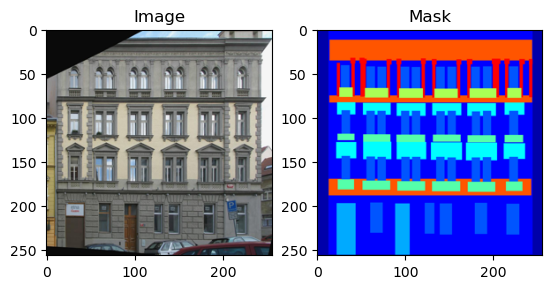

In [168]:
image, mask = next(iter(dataloader))
image = reverse_transform(image[0])
mask = reverse_transform(mask[0])
plot2x2Array(image, mask)

Initialize our GAN

In [169]:
# Calculate output of image discriminator (PatchGAN)
patch = (1, img_height//2**3-2, img_width//2**3-2)

if cuda:
    generator = generator.cuda()
    discriminator = discriminator.cuda()
    criterion_GAN.cuda()
    criterion_pixelwise.cuda()
    
# Optimizers
optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(b1, b2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(b1, b2))

Start training

In [170]:
def save_model(epoch):
    # save your work
    torch.save({
                'epoch': epoch,
                'model_state_dict': generator.state_dict(),
                'optimizer_state_dict': optimizer_G.state_dict(),
                'loss': loss_G,
                }, 'generator_'+str(epoch)+'.pth')
    torch.save({
                'epoch': epoch,
                'model_state_dict': discriminator.state_dict(),
                'optimizer_state_dict': optimizer_D.state_dict(),
                'loss': loss_D,
                }, 'discriminator_'+str(epoch)+'.pth')
    
def weights_init_normal(m):
  classname = m.__class__.__name__
  if classname.find('Conv') != -1:
      torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
  elif classname.find('BatchNorm2d') != -1:
      torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
      torch.nn.init.constant_(m.bias.data, 0.0)

<font color='red'>Complete the loss function </font>  in the following training code and train your network:  

In [171]:
# ----------
#  Training
# ----------

losses = []
num_epochs = 200

# Initialize weights
generator.apply(weights_init_normal)
discriminator.apply(weights_init_normal)
epoch_D = 0
epoch_G = 0

# Move models to GPU
generator = generator.cuda()
discriminator = discriminator.cuda()

# train the network
discriminator.train()
generator.train()
print_every = 400

for epoch in range(epoch_G, num_epochs):
    for i, batch in enumerate(dataloader):

        # Model inputs
        real_A = Variable(batch[0].type(Tensor)).cuda()
        real_B = Variable(batch[1].type(Tensor)).cuda()

        # Adversarial ground truths
        valid = Variable(Tensor(np.ones((real_B.size(0), *patch))), requires_grad=False)
        fake = Variable(Tensor(np.zeros((real_B.size(0), *patch))), requires_grad=False)

        # ------------------
        #  Train Generators
        # ------------------

        optimizer_G.zero_grad()

        # Generate a batch of images
        fake_A = generator(real_B)

        # GAN loss
        pred_fake = discriminator(fake_A, real_B)
        loss_GAN = criterion_GAN(pred_fake, valid)

        # Pixel-wise loss
        loss_pixel = torch.nn.functional.l1_loss(fake_A, real_A)

        # Total loss
        loss_G = loss_GAN + lambda_pixel * loss_pixel

        loss_G.backward()

        optimizer_G.step()

        # ---------------------
        #  Train Discriminator
        # ---------------------

        optimizer_D.zero_grad()

        # Real loss
        pred_real = discriminator(real_A, real_B)
        loss_real = criterion_GAN(pred_real, valid)

        # Fake loss
        pred_fake = discriminator(fake_A.detach(), real_B)
        loss_fake = criterion_GAN(pred_fake, fake)

        # Total loss
        loss_D = 0.5 * (loss_real + loss_fake)

        loss_D.backward()
        optimizer_D.step()
        
        # Print some loss stats
        if i % print_every == 0:
            # print discriminator and generator loss
            print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(
                    epoch+1, num_epochs, loss_D.item(), loss_G.item()))
    ## AFTER EACH EPOCH##
    # append discriminator loss and generator loss
    losses.append((loss_D.item(), loss_G.item()))
    if epoch % 100 == 0:
        print('Saving model...')
        save_model(epoch)


Epoch [    1/  200] | d_loss: 0.3022 | g_loss: 49.7155
Saving model...
Epoch [    2/  200] | d_loss: 0.2299 | g_loss: 18.5684
Epoch [    3/  200] | d_loss: 0.1707 | g_loss: 16.4951
Epoch [    4/  200] | d_loss: 0.0661 | g_loss: 17.6886
Epoch [    5/  200] | d_loss: 0.0773 | g_loss: 17.3891
Epoch [    6/  200] | d_loss: 0.1112 | g_loss: 15.5733
Epoch [    7/  200] | d_loss: 0.1227 | g_loss: 15.3706
Epoch [    8/  200] | d_loss: 0.0525 | g_loss: 16.4552
Epoch [    9/  200] | d_loss: 0.0122 | g_loss: 15.0118
Epoch [   10/  200] | d_loss: 0.0089 | g_loss: 15.3174
Epoch [   11/  200] | d_loss: 0.0038 | g_loss: 13.0277
Epoch [   12/  200] | d_loss: 0.0009 | g_loss: 12.4375
Epoch [   13/  200] | d_loss: 0.0009 | g_loss: 14.4673
Epoch [   14/  200] | d_loss: 0.0008 | g_loss: 13.2483
Epoch [   15/  200] | d_loss: 0.0011 | g_loss: 11.7375
Epoch [   16/  200] | d_loss: 0.0013 | g_loss: 12.3835
Epoch [   17/  200] | d_loss: 0.0004 | g_loss: 12.5036
Epoch [   18/  200] | d_loss: 0.0009 | g_loss: 11

Observation of the loss along the training

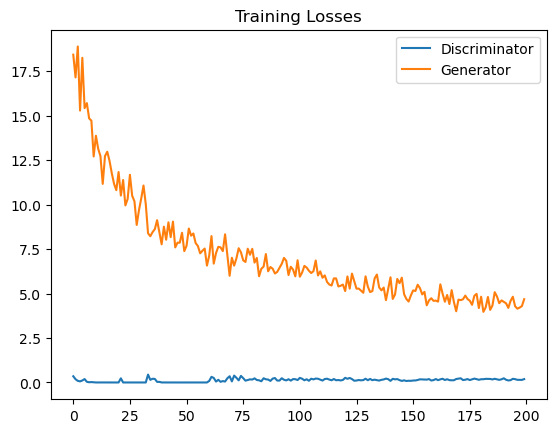

In [172]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator')
plt.plot(losses.T[1], label='Generator')
plt.title("Training Losses")
plt.legend()


If the training takes too much time, you can use a pretrained model in the meantime, to evaluate its performance.

It is available at : https://partage.liris.cnrs.fr/index.php/s/xwEFmxn9ANeq4zY

### Evaluate your cGAN

In [173]:
def load_model(epoch=200):
    if 'generator_'+str(epoch)+'.pth' in os.listdir() and 'discriminator_'+str(epoch)+'.pth' in os.listdir():
        if cuda:
            checkpoint_generator = torch.load('generator_'+str(epoch)+'.pth')
        else:
            checkpoint_generator = torch.load('generator_'+str(epoch)+'.pth', map_location='cpu')
        generator.load_state_dict(checkpoint_generator['model_state_dict'])
        optimizer_G.load_state_dict(checkpoint_generator['optimizer_state_dict'])
        epoch_G = checkpoint_generator['epoch']
        loss_G = checkpoint_generator['loss']

        if cuda:
            checkpoint_discriminator = torch.load('discriminator_'+str(epoch)+'.pth')
        else:
            checkpoint_discriminator = torch.load('discriminator_'+str(epoch)+'.pth', map_location='cpu')
        discriminator.load_state_dict(checkpoint_discriminator['model_state_dict'])
        optimizer_D.load_state_dict(checkpoint_discriminator['optimizer_state_dict'])
        epoch_D = checkpoint_discriminator['epoch']
        loss_D = checkpoint_discriminator['loss']
    else:
        print('There isn\' a training available with this number of epochs')

In [174]:
load_model(epoch=200)

# switching mode
generator.eval()

There isn' a training available with this number of epochs


U_Net(
  (inc): inconv(
    (conv): Sequential(
      (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): LeakyReLU(negative_slope=0.2, inplace=True)
    )
  )
  (down1): down(
    (conv): Sequential(
      (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
  )
  (down2): down(
    (conv): Sequential(
      (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
  )
  (down3): down(
    (conv): Sequential(
      (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inpla

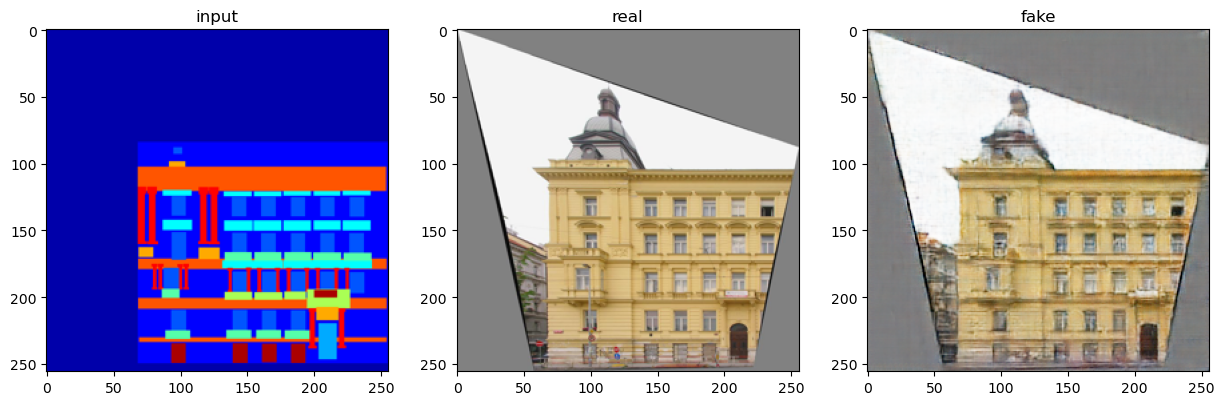

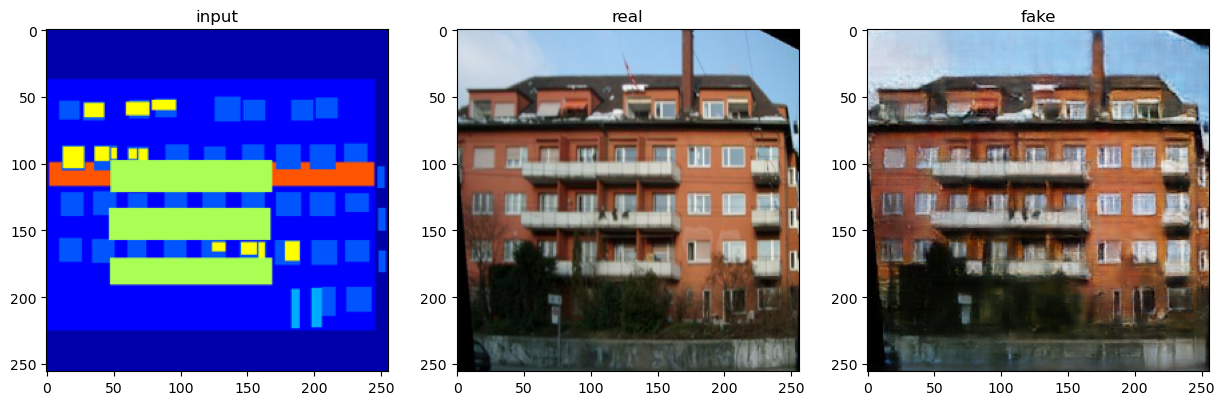

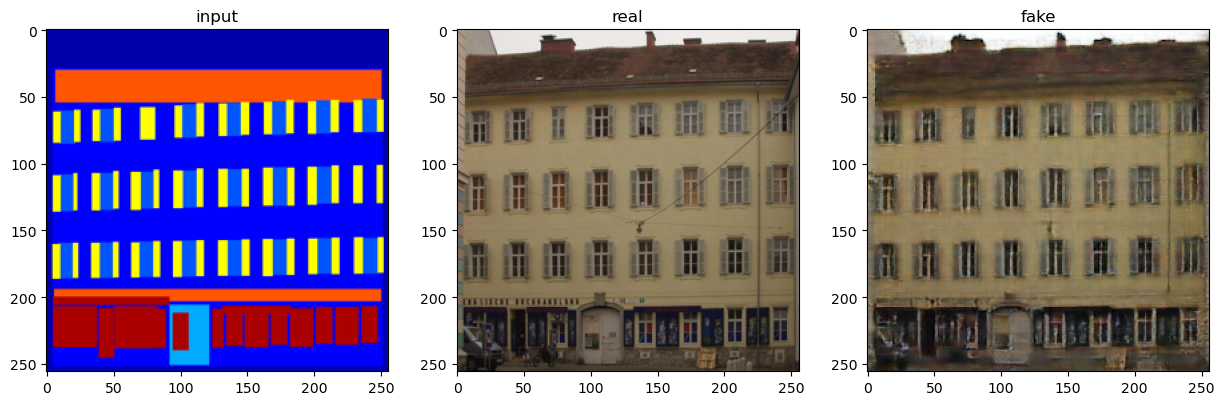

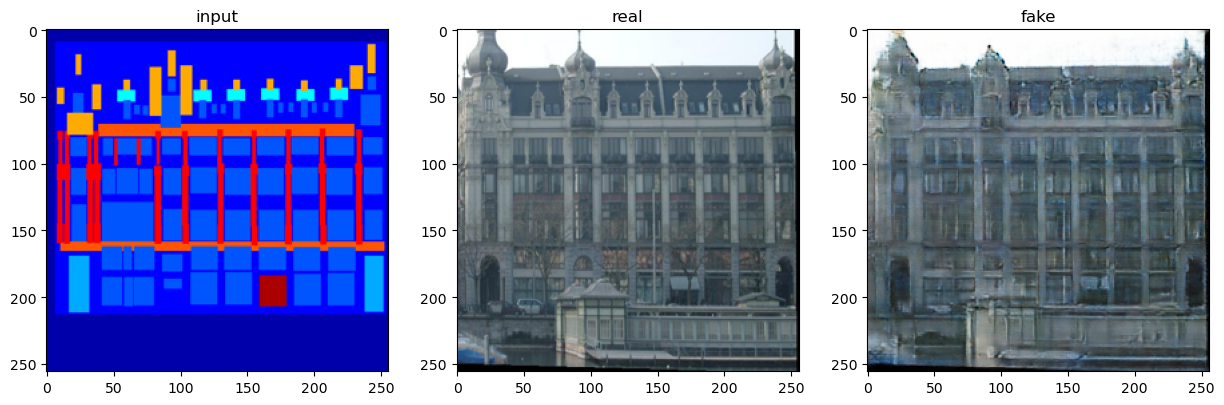

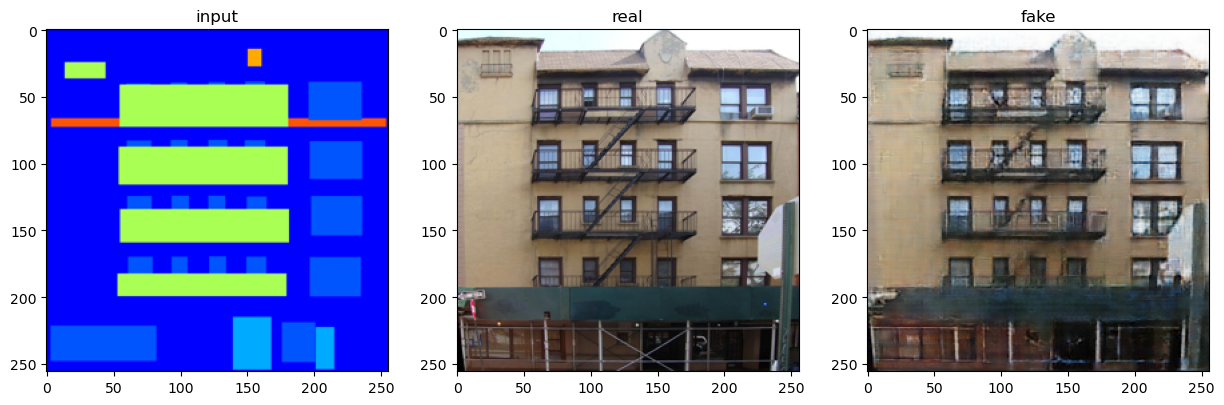

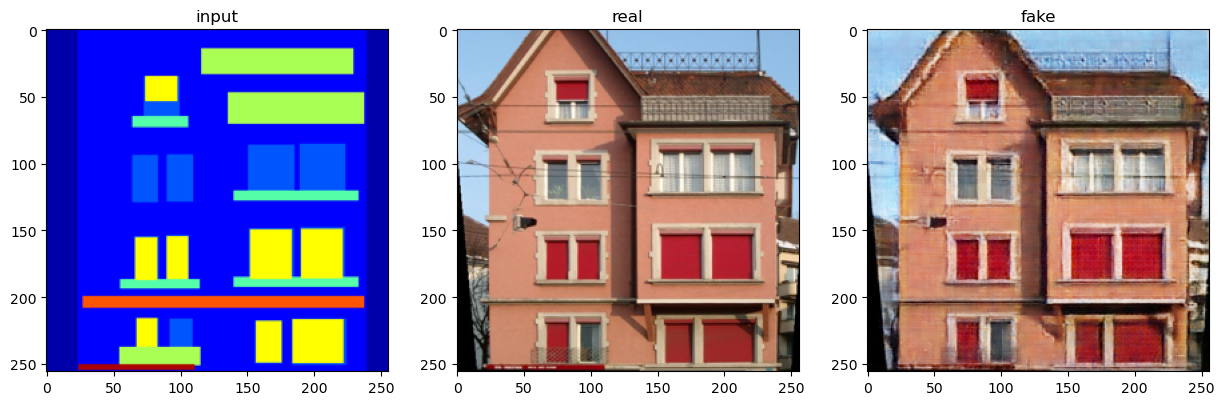

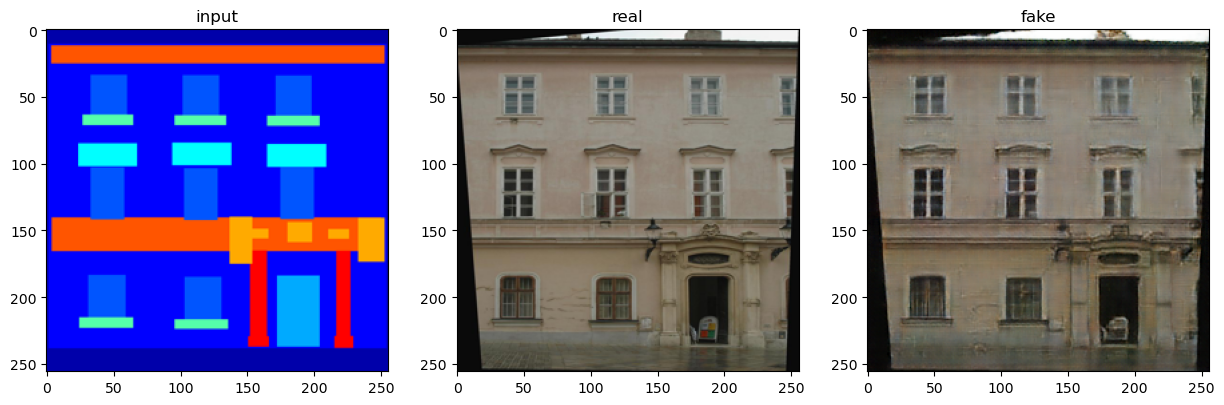

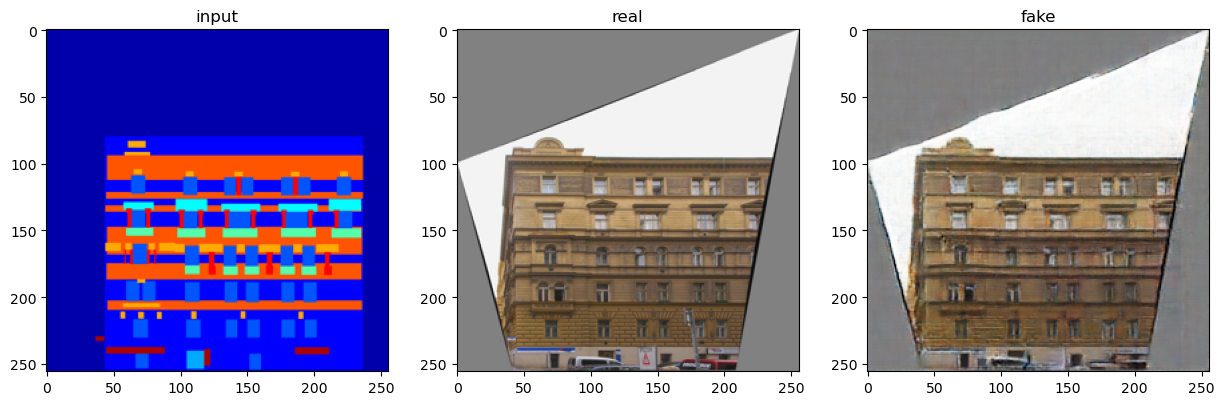

In [175]:
# show a sample evaluation image on the training base
image, mask = next(iter(dataloader))
output = generator(mask.type(Tensor))
output = output.view(16, 3, 256, 256)
output = output.cpu().detach()
for i in range(8):
    image_plot = reverse_transform(image[i])
    output_plot = reverse_transform(output[i])
    mask_plot = reverse_transform(mask[i])
    plot2x3Array(mask_plot,image_plot,output_plot)

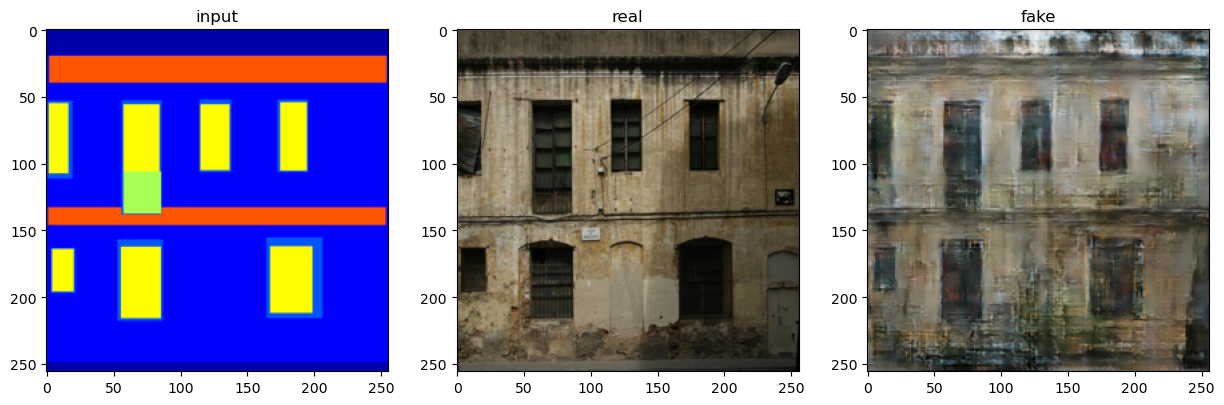

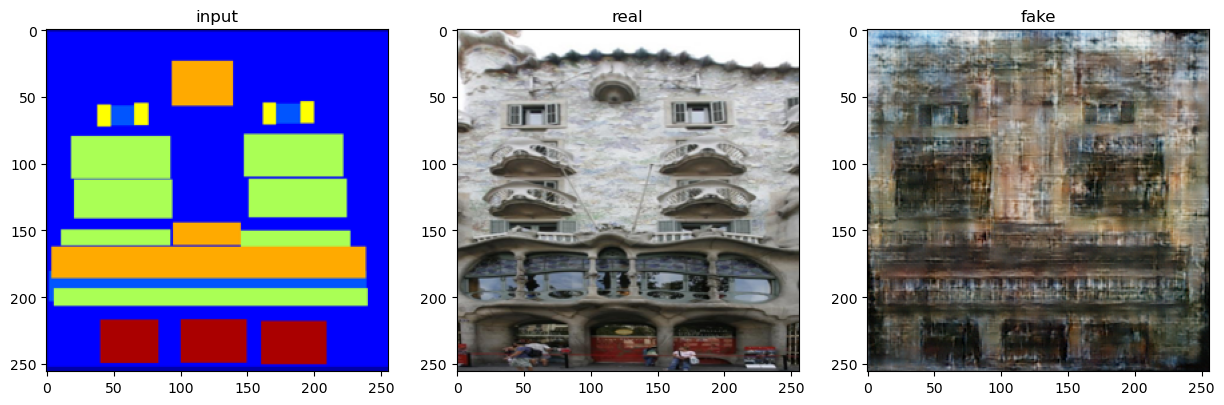

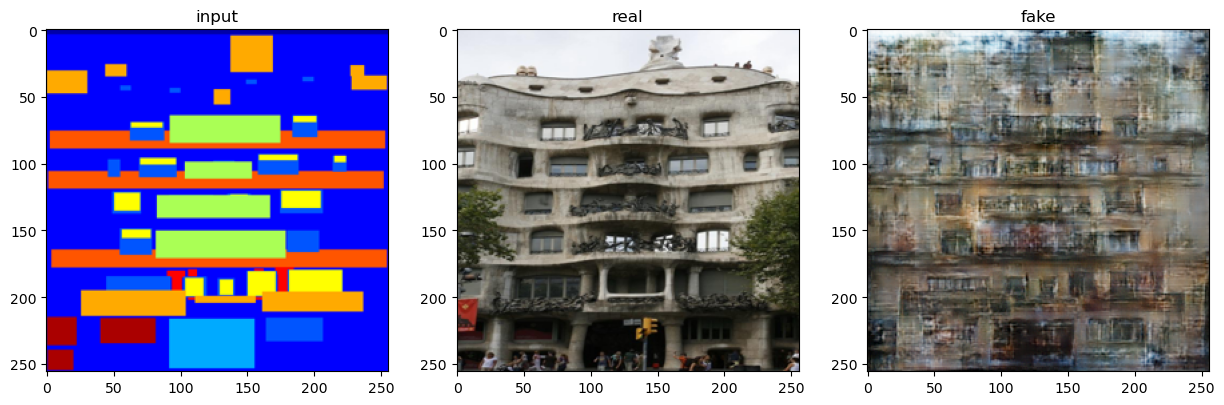

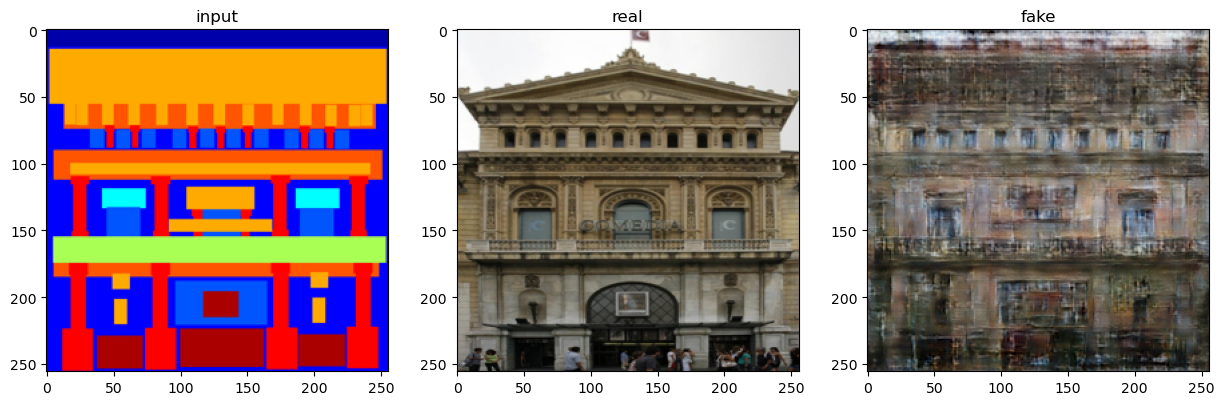

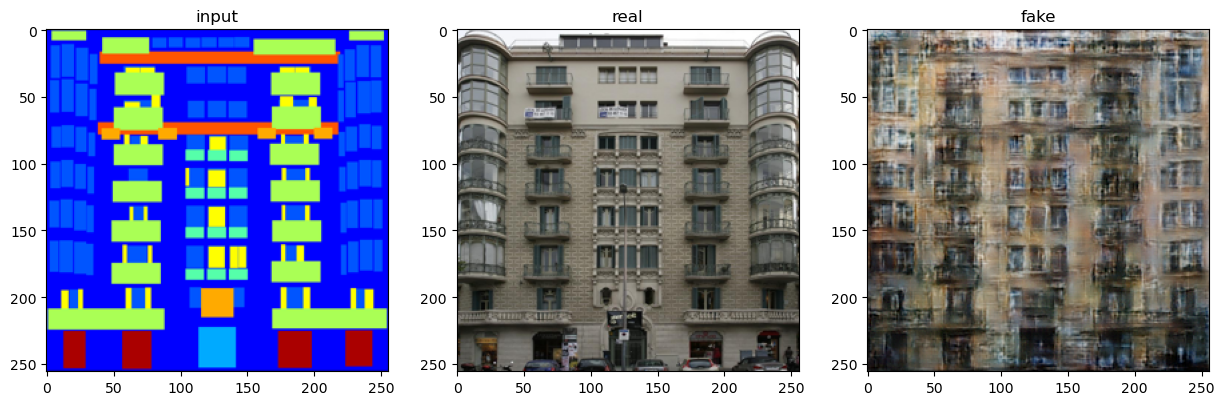

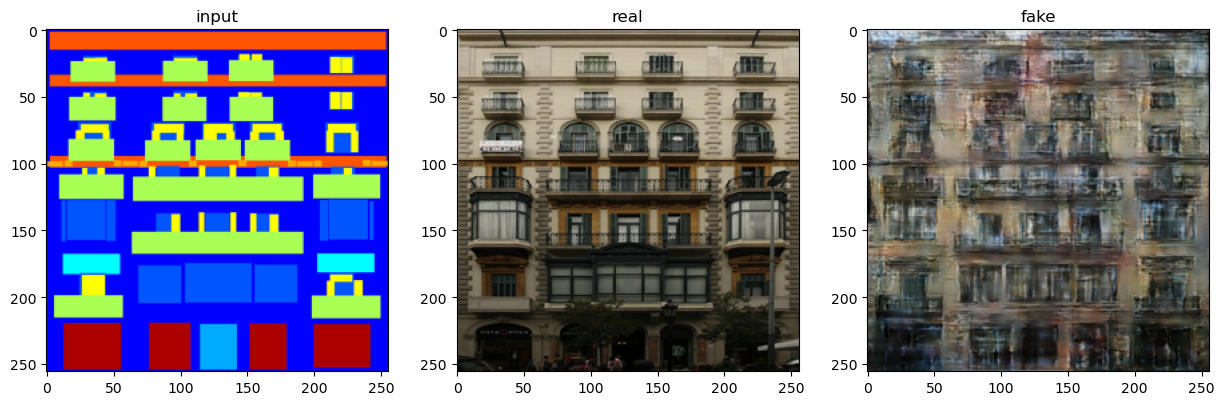

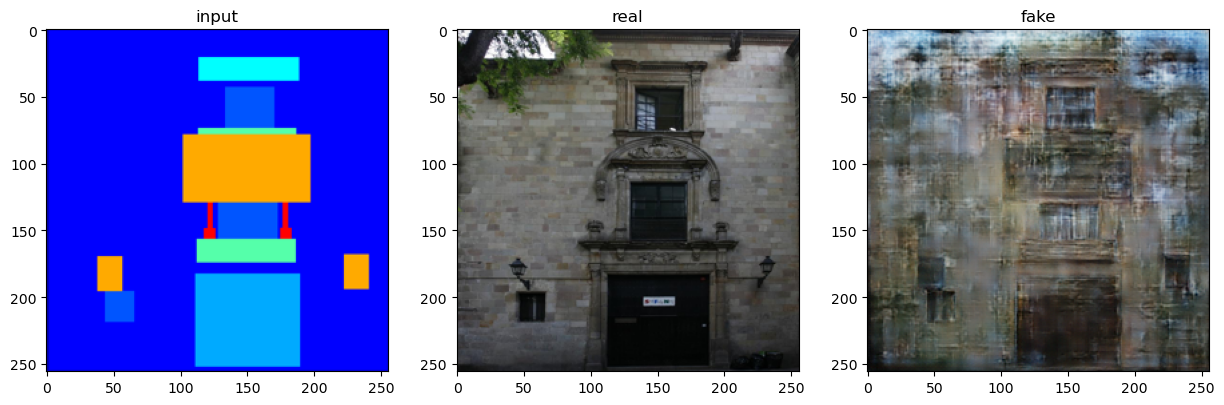

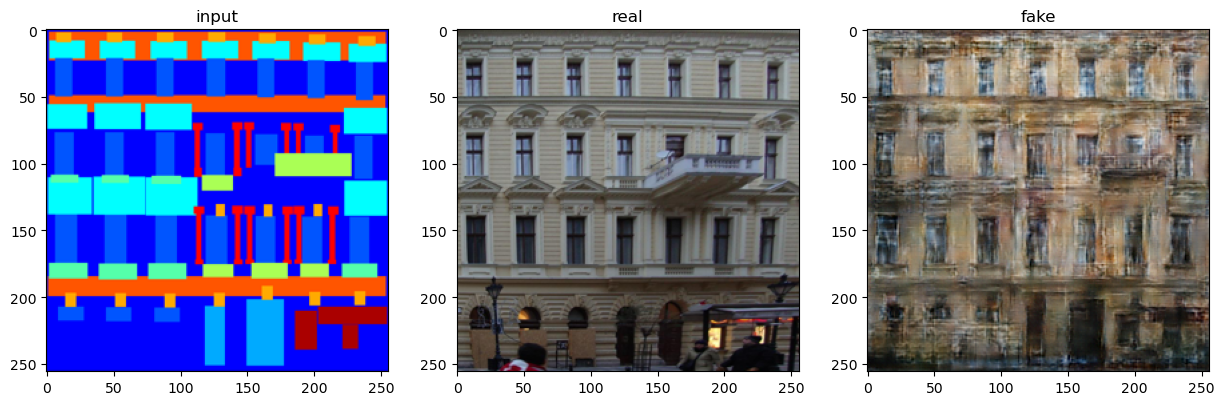

In [176]:
# show a sample evaluation image on the validation dataset
image, mask = next(iter(val_dataloader))
output = generator(mask.type(Tensor))
output = output.view(8, 3, 256, 256)
output = output.cpu().detach()
for i in range(8):
    image_plot = reverse_transform(image[i])
    output_plot = reverse_transform(output[i])
    mask_plot = reverse_transform(mask[i])
    plot2x3Array(mask_plot,image_plot,output_plot)

<font color='red'>**Question 4**</font>                                                                  
Compare results for 100 and 200 epochs

In [177]:
# TO DO : Your code here to load and evaluate with a few samples
#         a model after 100 epochs



In [178]:
# And finally :
if cuda:
    torch.cuda.empty_cache()

# How to submit your Work ?

This work must be done individually. The expected output is a private repository named gan-cgan on https://gitlab.ec-lyon.fr. It must contain your notebook (or python files) and a README.md file that explains briefly the successive steps of the project. Don't forget to add your teacher as developer member of the project. The last commit is due before 11:59 pm on Monday, April 1st, 2024. Subsequent commits will not be considered.